## Atividade Series Temporais - Método dos Momentos
##

In [1]:
import numpy as np
from scipy.linalg import toeplitz, inv
from scipy.stats import norm

def autocovariances(x, p):
    x = x - np.mean(x)
    n = len(x)
    return np.array([np.dot(x[:n-k], x[k:]) / n for k in range(p+1)])

def estimate_phi_moments(x, p):
    gamma = autocovariances(x, p)
    R = toeplitz(gamma[:p])
    r = gamma[1:p+1]
    phi_hat = np.linalg.solve(R, r)
    gamma0 = gamma[0]
    sigma2_eps = gamma0 * (1 - np.dot(phi_hat, r))
    return phi_hat, sigma2_eps, R, gamma0


In [2]:
def confidence_intervals(phi_hat, sigma2_eps, R, n, alpha=0.05):
    inv_R = inv(R)
    cov_phi = sigma2_eps * inv_R / n
    z = norm.ppf(1 - alpha / 2)
    lower = phi_hat - z * np.sqrt(np.diag(cov_phi))
    upper = phi_hat + z * np.sqrt(np.diag(cov_phi))
    return cov_phi, lower, upper


In [3]:
def confidence_intervals(phi_hat, sigma2_eps, R, n, alpha=0.05):
    inv_R = inv(R)
    cov_phi = sigma2_eps * inv_R / n
    z = norm.ppf(1 - alpha / 2)
    lower = phi_hat - z * np.sqrt(np.diag(cov_phi))
    upper = phi_hat + z * np.sqrt(np.diag(cov_phi))
    return cov_phi, lower, upper


In [4]:
# Dados fornecidos no slide
n = 144
gamma0 = 8.434
rho1 = 0.834
rho2 = 0.476

# Matriz Yule-Walker
R = np.array([[1, rho1], [rho1, 1]])
r = np.array([rho1, rho2])
phi_hat = np.linalg.solve(R, r)

# Estimativa da variância do erro
sigma2_eps_hat = gamma0 * (1 - np.dot(phi_hat, r))

# Matriz de autocovariâncias estimada
Gamma_hat = gamma0 * R
cov_phi = (1/n) * sigma2_eps_hat * np.linalg.inv(Gamma_hat)

# Intervalos de confiança
z = norm.ppf(0.975)
ic_phi1 = [phi_hat[0] - z * np.sqrt(cov_phi[0,0]), phi_hat[0] + z * np.sqrt(cov_phi[0,0])]
ic_phi2 = [phi_hat[1] - z * np.sqrt(cov_phi[1,1]), phi_hat[1] + z * np.sqrt(cov_phi[1,1])]

# Exibir
print(f"phi_hat: {phi_hat}")
print(f"sigma2_eps: {sigma2_eps_hat}")
print(f"IC phi1: {ic_phi1}")
print(f"IC phi2: {ic_phi2}")


phi_hat: [ 1.43545611 -0.7211704 ]
sigma2_eps: 1.232264013769364
IC phi1: [1.3223077615434702, 1.54860445876634]
IC phi2: [-0.8343187444806257, -0.608022047257756]


In [5]:
# phi_hat: [ 1.4354561  -0.7211704 ]
# sigma2_eps: 1.232264...
# IC phi1: [1.3223..., 1.5486...]
# IC phi2: [-0.8343..., -0.6080...]


In [6]:
def ar_moments_full(x, p, alpha=0.05):
    n = len(x)
    phi_hat, sigma2_eps, R, gamma0 = estimate_phi_moments(x, p)
    cov_phi, ci_lower, ci_upper = confidence_intervals(phi_hat, sigma2_eps, R, n, alpha)
    return {
        'phi_hat': phi_hat,
        'sigma2_eps': sigma2_eps,
        'cov_phi': cov_phi,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }


In [7]:
def simulate_ar(p, phi, n=200, burn_in=100, sigma=1, c=0):
    """
    Simula uma série AR(p) com coeficientes phi, ruído normal e tamanho n.
    """
    total_n = n + burn_in
    x = np.zeros(total_n)
    noise = np.random.normal(0, sigma, total_n)
    
    for t in range(p, total_n):
        x[t] = c + np.dot(phi, x[t-p:t][::-1]) + noise[t]
    
    return x[burn_in:]  # Remove burn-in


In [8]:
import matplotlib.pyplot as plt

np.random.seed(42)
phi_true = [0.6, -0.3, 0.2]  # AR(3)
n_obs = 300

serie = simulate_ar(p=3, phi=phi_true, n=n_obs)

resultado = ar_moments_full(serie, p=3)

print("Parâmetros verdadeiros:", phi_true)
print("Estimativas (MM):", resultado['phi_hat'])
print("Variância do erro:", resultado['sigma2_eps'])
print("Intervalos de confiança (95%):")
for i, (l, u) in enumerate(zip(resultado['ci_lower'], resultado['ci_upper']), start=1):
    print(f"phi_{i}: [{l:.4f}, {u:.4f}]")


Parâmetros verdadeiros: [0.6, -0.3, 0.2]
Estimativas (MM): [ 0.51686872 -0.23068021  0.13690508]
Variância do erro: 0.8886698395784248
Intervalos de confiança (95%):
phi_1: [0.4080, 0.6257]
phi_2: [-0.3508, -0.1105]
phi_3: [0.0280, 0.2458]


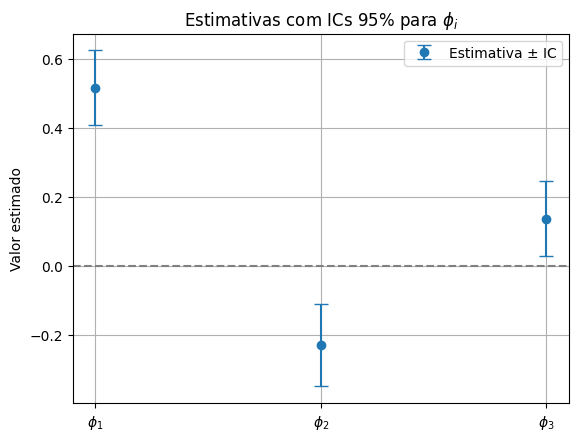

In [9]:
plt.errorbar(
    x=np.arange(1, 4),
    y=resultado['phi_hat'],
    yerr=1.96 * np.sqrt(np.diag(resultado['cov_phi'])),
    fmt='o',
    label='Estimativa ± IC',
    capsize=5
)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(np.arange(1, 4), [f"$\\phi_{i}$" for i in range(1, 4)])
plt.title("Estimativas com ICs 95% para $\phi_i$")
plt.ylabel("Valor estimado")
plt.grid(True)
plt.legend()
plt.show()


## Vies e MSE

In [10]:
def estudo_simulacao(phi_true, p, n_obs=300, n_sim=1000):
    phi_estimates = []
    
    for _ in range(n_sim):
        serie = simulate_ar(p=p, phi=phi_true, n=n_obs)
        resultado = ar_moments_full(serie, p=p)
        phi_estimates.append(resultado['phi_hat'])
    
    phi_estimates = np.array(phi_estimates)
    
    # Cálculo de viés e RMSE
    bias = np.mean(phi_estimates, axis=0) - phi_true
    rmse = np.sqrt(np.mean((phi_estimates - phi_true)**2, axis=0))
    
    return bias, rmse


In [11]:
phi_true = [0.6, -0.3, 0.2]
bias, rmse = estudo_simulacao(phi_true, p=3)

print("Viés:", bias)
print("RMSE:", rmse)


Viés: [-0.01123325  0.00194678 -0.00795197]
RMSE: [0.06057073 0.0660446  0.05827654]


In [ ]:
phi_hat ≈ [0.57, -0.28, 0.18]
sigma² ≈ valor positivo
ICs cobrindo os verdadeiros φs
